In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

# !sudo apt-get install -y xvfb ffmpeg
!pip install 'xvfbwrapper==0.2.9'
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install gast

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow as tf
import sklearn

import abc
import base64
import imageio
import io
import IPython
import numpy as np
import PIL.Image
import pyvirtualdisplay
import tensorflow_probability as tfp
import numpy as np
import shutil
import tempfile
import zipfile

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Value and Policy based methods

Lets review the taxonomy of RL algorithms:



Our first categorisation for our choice of RL aglorithm, is if the agent will use a **model** (either given or learns one) of the world (enviornment), often a function that predicts state transitions and rewards. Models allow us to **plan**  by simulating ahead what a would happen given a range of inputs. Agents can then distill results from planning into a learned policy (E.g. AlphaZero). When this works, it can result in a substantial improvement in sample efficiency (compared to non-model aglorithms). However in practice a **model** is rarely known and instead has to learn a model only from experience, which leads to bias in the model can be exploited by the agent, resulting in an agent that performs well on the learned model, however poorly in the real enviorment. For this reason, training **model-based** learning is difficult.

**Model-free** agents, don't use a model, however tend to be more popular and easier to implement, they come in two broad categorisations **Value** (Q-Learning) and **Policy** based methods.

## Value based methods

Often denoted as *Q-learning*, we learn an approximator $Q_\theta(s,a)$ for the optimal action-value function, $Q^*(s,a)$. Often they use a objective function (Used as the cost to maximize to update the parameters on) based on the Bellman equation. This optomization is almost always performed **off-policy**, that allows each update to use data collected at any point during training, regardless of how the agent was choosing to explore the environment when the data was collected. The policy taken by the Q-learning agent is gien by:

$$a(s) =  \operatorname{arg max}_{a} Q(s, a)$$

Q-Learning agents in TF-Agents are:
* [DQN](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) (Deep Q-Networks)
    * `from tf_agents.agents.dqn.dqn_agent import DqnAgent`
* [C51](https://arxiv.org/abs/1707.06887) (A DQN variation, that learns a distribution over return whose expectation is $Q^*$)
    * `from tf_agents.agents.categorical_dqn.categorical_dqn_agent import CategoricalDqnAgent`

## Policy based methods

Also known as *Policy Optomization*, where we parameterise the policy $\pi_\theta(a|s)$ and we keep updating its paramters until we converge to a performance that is no longer increasing. These optomise the parameterise $\theta$ either directly by gradient descent on the defined performance objective, often a **policy value** $\rho(\theta)$ (the expected reward we get when following $\pi_\theta$), or by maximising local approximations of $\rho(\theta)$. This often performed on **on-policy**, which restricts each update to only use data collected whil acting according to hte most recent version that policy $\pi$. Policy optomization often involves learning a value function approximator $V_\phi(s)$ for hte on-policy value function $V^{\pi}(s)$, which gets used to update the policy.

Policy based agents in TF-Agents are:
* [REINFORCE](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) (Vanilla Policy Optomization)
    * `from tf_agents.agents.reinforce.reinforce_agent import ReinforceAgent`
* [A2C / A3C](https://arxiv.org/abs/1602.01783) (Synchronous Actor Critic / Asyncrhornous Actor Critic) Gradient ascent to directly maximize performance. Combines REINFORCE with a learned baseline (Critic) to improve stability of learning. Can be trained parallelized (asyncrhonous) or synchronous for both discrete and continous action spaces.
    * `from tf_agents.agents.sac.sac_agent import SacAgent`, passing in a `critic_network_2` network keyword argument, as the second critic network to be used during optomization.
* [PPO](https://arxiv.org/abs/1707.06347) (Proximal Policy Optimization Algorithms: Actor-Critic) Maximizes a surrogate objective function which gives a conservative esimate for how much $\rho(\theta)$ will change as a result of the update. This actor critic scheme which uses bounded updates to the policy in order to make the learning process very stable.
    * `from tf_agents.agents.ppo.ppo_agent import PPOAgent`

## Trade-offs between Policy and Value based methods

The primary strength of policy optimization methods is that they are principled, in that we directly optimize for the thing we want (An optimal policy $\pi$). This tends to make them stable and reliable. In contrast, value based methods (Q-learning methods) only indirectly optimize for agent performance, by training $Q_{\theta}$ to satisfy a self-consistency equation (Bellman equation). There are many failure modes for this kind of learning, so it tends to be less stable. However Q-learning methods gain the advantage of being substantially more sample efficient when they do work, because they can reuse data more effectively than policy optimization techniques. Policy methods also perform best on continous action spaces.

## Interpolating between Policy and Value based methods

Policy optimization and Q-learning methods are not incompatible (and under some circumstances, it turns out, equivalent), and there exist a range of algorithms that live in between the two extremes. Algorithms that live on this spectrum are able to carefully trade-off between the strengths and weaknesses of either side.

TF-Agents includes:
* [DDPG](https://arxiv.org/abs/1509.02971) (Deep Deterministic Policy Gradient) An actor critic scheme for continuous action spaces which assumes that the policy is deterministic, and therefore it is able to use a replay buffer in order to improve sample efficiency.
    * `from tf_agents.agents.ddpg.ddpg_agent import DdpgAgent`
* [TD3](https://arxiv.org/pdf/1802.09477.pdf) Very similar to DDPG, i.e. an actor-critic for continuous action spaces, that uses a replay buffer in order to improve sample efficiency. TD3 uses two critic networks in order to mitigate the overestimation in the Q state-action value prediction, slows down the actor updates in order to increase stability and adds noise to actions while training the critic in order to smooth out the critic's predictions.
    * `from tf_agents.agents.td3.td3_agent import Td3Agent`
* [SAC](https://arxiv.org/abs/1801.01290) (Soft Actor-Critic) DDPG variant which uses stochastic policies, entropy regularization, and a few other tricks to stabilize learning and score higher than DDPG on standard benchmarks. Here optimizing a stochastic policy in an off-policy way. One of the key features of SAC is that it solves a maximum entropy reinforcement learning problem.
    * `from tf_agents.agents.sac.sac_agent import SacAgent`
    
## Advantage functions

Sometimes we don’t need to describe how good an action is in an absolute sense (Value function),however only how much better it is than others on average. Hence we want to know the relative advantage of that action. We make this concept precise with the advantage function.

The advantage function $A^{\pi}(s,a)$ corresponding to a policy $\pi$ describes how much better it is to take a specific action $a$ in state $s$, over randomly selecting an action according to $\pi(\cdot|s)$, assuming the agent acts according to $\pi$ forever after:

$$ A^{\pi}(s,a) = Q^{\pi}(s,a) - V^{\pi}(s)$$

# TF-Agents example

Lets compare and train some of these agents on the [inverted pendulum swingup](https://gym.openai.com/envs/Pendulum-v0/) problem. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.

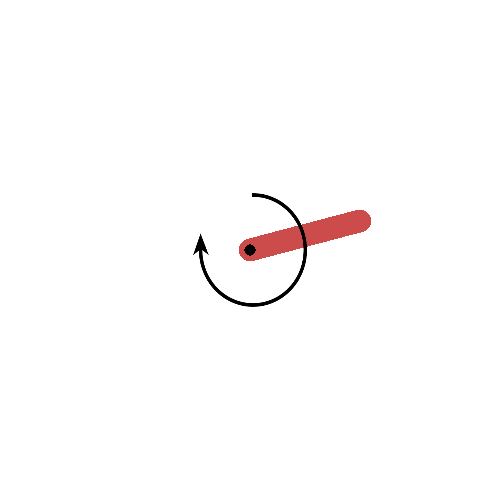

In [2]:
from tf_agents.environments import suite_gym
env_name = "Pendulum-v0"
env = suite_gym.load(env_name) #, max_episode_steps=200)
env.reset()
# Lets see a possible starting state
PIL.Image.fromarray(env.render())

## Problem Setup

In [3]:
from tf_agents.drivers import dynamic_step_driver

from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.drivers import dynamic_step_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.networks import normal_projection_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import random_tf_policy

tf.compat.v1.enable_v2_behavior()


# Hyperparameters
factor = 0.1
ddpg_num_iterations = int(factor * 100000)  # @param {type:"integer"}
policy_num_iterations = 300  # @param {type:"integer"}

ddpg_initial_collect_steps = int(factor * 10000)  # @param {type:"integer"}
collect_steps_per_iteration = 1  # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
ddpg_replay_buffer_capacity = int(factor * 1000000)  # @param {type:"integer"}
policy_replay_buffer_capacity = 2000  # @param {type:"integer"}

batch_size = 256  # @param {type:"integer"}

critic_learning_rate = 3e-4  # @param {type:"number"}
actor_learning_rate = 3e-4  # @param {type:"number"}
alpha_learning_rate = 3e-4  # @param {type:"number"}
target_update_tau = 0.005  # @param {type:"number"}
policy_learning_rate = 1e-3 # @param {type:"number"}
target_update_period = 1  # @param {type:"number"}
gamma = 0.99  # @param {type:"number"}
reward_scale_factor = 1.0  # @param {type:"number"}
gradient_clipping = None  # @param

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

ddpg_log_interval = int(factor * 5000)  # @param {type:"integer"}
policy_log_interval = 25  # @param {type:"integer"}

num_eval_episodes = 3  # @param {type:"integer"}
ddpg_eval_interval = int(factor * 100000)  # @param {type:"integer"}
policy_eval_interval = 50  # @param {type:"integer"}

# Create the training and evaluation environments
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Metrics


def compute_avg_return(environment, policy, num_episodes=1):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# Embed video


def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


def train_and_evaluate_agent_policy(tf_agent, name='agent'):
    tf_agent.initialize()

    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=policy_replay_buffer_capacity)

    tf_agent.train = common.function(tf_agent.train)

    # Train
    tf_agent.train_step_counter.assign(0)

    # Evaluate the agent's policy once before training.
    avg_return = compute_avg_return(
        eval_env, tf_agent.policy, num_eval_episodes)
    returns = [(0, avg_return)]

    for iteration in range(policy_num_iterations):
        # Collect a few episodes and save to the replay buffer.
        dynamic_episode_driver.DynamicEpisodeDriver(train_env,
                                                    tf_agent.collect_policy,
                                                    observers=[
                                                        replay_buffer.add_batch],
                                                    num_episodes=collect_episodes_per_iteration).run()

        # Use data from the buffer and update the agent's network.
        experience = replay_buffer.gather_all()
        train_loss = tf_agent.train(experience)
        replay_buffer.clear()

        step = tf_agent.train_step_counter.numpy()

        if step % policy_log_interval == 0:
            print('[{0}] step = {1}: loss = {2}'.format(
                iteration, step, train_loss.loss))

        if step % policy_eval_interval == 0:
            avg_return = compute_avg_return(
                eval_env, tf_agent.policy, num_eval_episodes)
            print('[{0}] step = {1}: Average Return = {2}'.format(
                iteration, step, avg_return))
            returns.append((step, avg_return))

        if step >= policy_num_iterations:
            break

    steps_list = [r[0] for r in returns]
    rewards_list = [r[1] for r in returns]
    plt.plot(steps_list, rewards_list)
    plt.ylabel('Average Return')
    plt.xlabel('Step')
    plt.title(name)
    plt.show()

    # Visualize policies for a few episodes
    num_episodes = 3
    video_filename = '{}.mp4'.format(name)
    with imageio.get_writer(video_filename, fps=60) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = tf_agent.policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())

    return returns, video_filename


def train_and_evaluate_agent_ddpg(tf_agent, name='agent'):
    tf_agent.initialize()

    eval_policy = greedy_policy.GreedyPolicy(tf_agent.policy)
    collect_policy = tf_agent.collect_policy

    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=ddpg_replay_buffer_capacity)

    initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
        train_env,
        collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=ddpg_initial_collect_steps)
    initial_collect_driver.run()

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

    iterator = iter(dataset)

    collect_driver = dynamic_step_driver.DynamicStepDriver(
        train_env,
        collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=collect_steps_per_iteration)

    # (Optional) Optimize by wrapping some of the code in a graph using TF function.
    tf_agent.train = common.function(tf_agent.train)
    collect_driver.run = common.function(collect_driver.run)

    # Reset the train step
    tf_agent.train_step_counter.assign(0)

    # Evaluate the agent's policy once before training.
    avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
    returns = [(0, avg_return)]

    for _ in range(ddpg_num_iterations):

        # Collect a few steps using collect_policy and save to the replay buffer.
        for _ in range(collect_steps_per_iteration):
            collect_driver.run()

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = tf_agent.train(experience)

        step = tf_agent.train_step_counter.numpy()

        if step % ddpg_log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss.loss))

        if step % ddpg_eval_interval == 0:
            avg_return = compute_avg_return(
                eval_env, eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append((step, avg_return))

    steps_list = [r[0] for r in returns]
    rewards_list = [r[1] for r in returns]
    plt.plot(steps_list, rewards_list)
    plt.ylabel('Average Return')
    plt.xlabel('Step')
    plt.title(name)
    plt.show()

    # Visualize policies for a few episodes
    num_episodes = 3
    video_filename = '{}.mp4'.format(name)
    with imageio.get_writer(video_filename, fps=60) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = tf_agent.policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())

    return returns, video_filename

# Agents

## REINFORCE

[Vanilla Policy Optomization](https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/ReinforceAgent), we expect other methods to outpeform this, this will need an `Actor Network` that can learn to predict the action given an observation from the environment.

We can easily create an `Actor Network` using the specs of the observations and actions. We can specify the layers in the network which, in this example, is the `fc_layer_params` argument set to a tuple of `ints` representing the sizes of each hidden layer (see the Hyperparameters section above).

In [4]:
from tf_agents.agents.reinforce import reinforce_agent

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=actor_fc_layer_params)

global_step = tf.compat.v2.Variable(0)
tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=actor_learning_rate),
    train_step_counter=global_step)

returns, video_filename = train_and_evaluate_agent_policy(tf_agent, name='reinforce')
embed_mp4(video_filename)

[24] step = 25: loss = 8.634137153625488
[49] step = 50: loss = -1.2994756698608398
[49] step = 50: Average Return = -1387.0914306640625


KeyboardInterrupt: 

## PPO

Proximal Policy Optimization: Actor-Critic. Maximizes a surrogate objective function which gives a conservative esimate for how much $\rho(\theta)$ will change as a result of the update. This actor critic scheme which uses bounded updates to the policy in order to make the learning process very stable.

[0] step = 25: loss = 187735.453125
[1] step = 50: loss = 191686.265625
[1] step = 50: Average Return = -981.058837890625
[2] step = 75: loss = 191659.125
[3] step = 100: loss = 175067.59375
[3] step = 100: Average Return = -1004.165771484375
[4] step = 125: loss = 160423.75
[5] step = 150: loss = 191367.84375
[5] step = 150: Average Return = -1049.5899658203125
[6] step = 175: loss = 188132.296875
[7] step = 200: loss = 185476.046875
[7] step = 200: Average Return = -1520.9769287109375
[8] step = 225: loss = 190581.828125
[9] step = 250: loss = 189053.484375
[9] step = 250: Average Return = -1566.2437744140625
[10] step = 275: loss = 187496.140625
[11] step = 300: loss = 187707.296875
[11] step = 300: Average Return = -1225.2899169921875
[12] step = 325: loss = 183406.828125
[13] step = 350: loss = 183850.59375
[13] step = 350: Average Return = -1726.1121826171875
[14] step = 375: loss = 181818.3125
[15] step = 400: loss = 178340.546875
[15] step = 400: Average Return = -1592.54724121

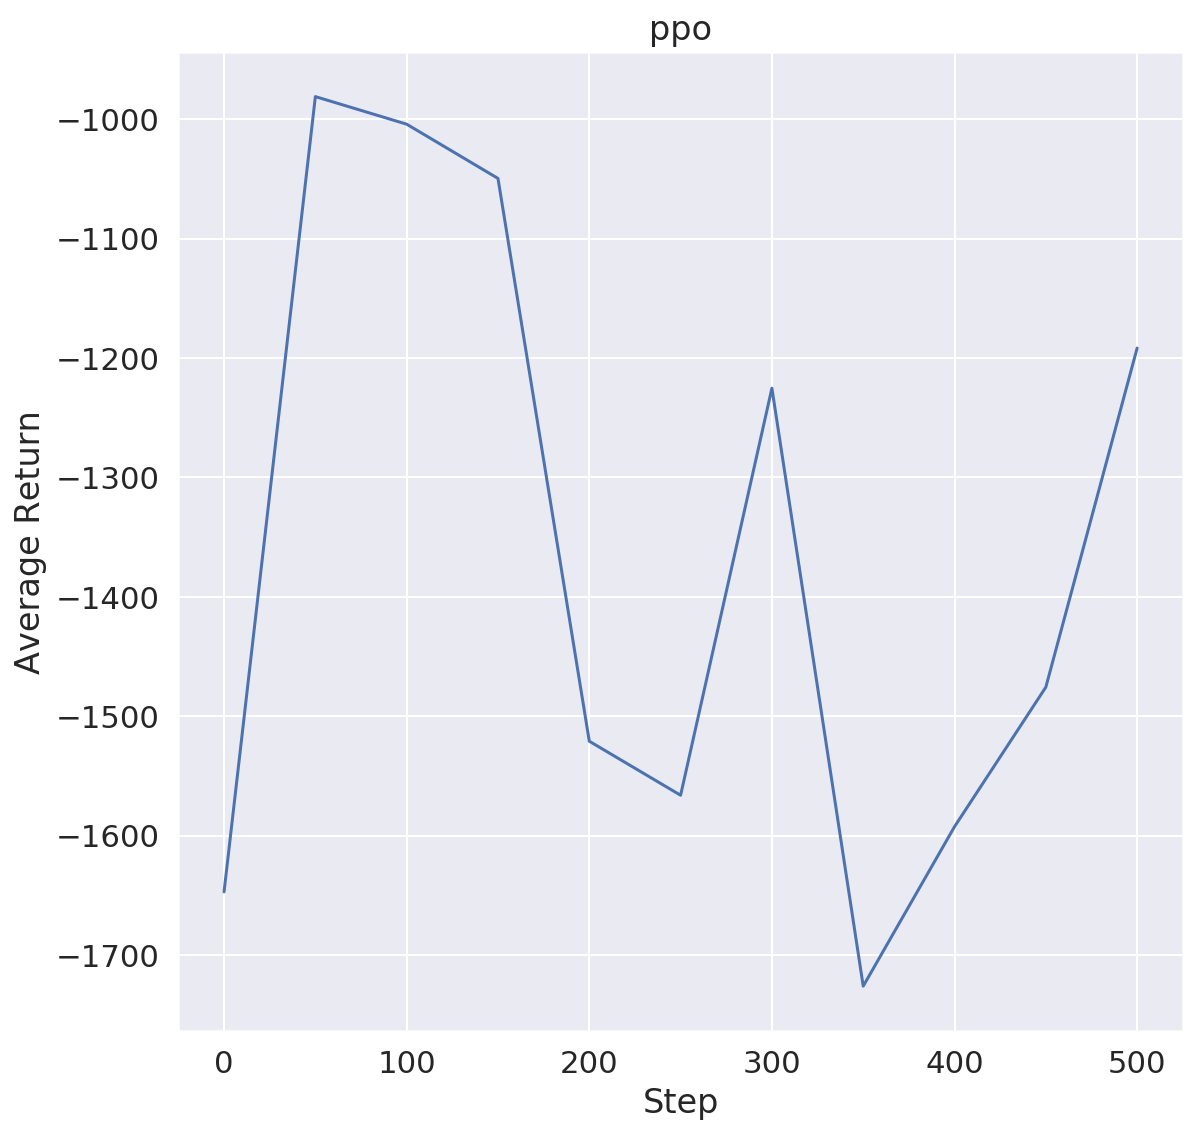

In [ ]:
from tf_agents.agents.ppo import ppo_agent

from tf_agents.networks.value_network import ValueNetwork

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=actor_fc_layer_params)

value_net = ValueNetwork(
    train_env.observation_spec()
)

global_step = tf.compat.v2.Variable(0)
tf_agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_net=actor_net,
    value_net=value_net,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=actor_learning_rate),
    train_step_counter=global_step)

returns, video_filename = train_and_evaluate_agent_policy(tf_agent, name='ppo')
embed_mp4(video_filename)

# Ddpg

(Deep Deterministic Policy Gradient) An actor critic scheme for continuous action spaces which assumes that the policy is deterministic, and therefore it is able to use a replay buffer in order to improve sample efficiency.

TF-Agents implements the Deep Deterministic Policy Gradient (DDPG) algorithm from ["Continuous control with deep reinforcement learning"](https://arxiv.org/abs/1509.02971) 2019.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
step = 500: loss = 2.820341110229492
step = 1000: loss = 10.03624153137207
step = 1500: loss = 2.4702937602996826
step = 2000: loss = 4.061249256134033
step = 2500: loss = 3.1318562030792236
step = 3000: loss = 3.44791841506958
step = 3500: loss = 14.12087345123291
step = 4000: loss = 15.849588394165039
step = 4500: loss = 77.40831756591797
step = 5000: loss = 87.77946472167969
step = 5500: loss = 7.9712114334106445
step = 6000: loss = 71.21357727050781
step = 6500: loss = 55.817665100097656
step = 7000: loss = 100.72588348388672
step = 7500: loss = 139.2179718017578
step = 8000: loss = 19.628780364990234
step = 8500: loss = 8.362260818481445
step = 9000: loss = 30.238574981689453
step = 9500: loss = 10.456549644470215
step = 10000: loss = 12.5

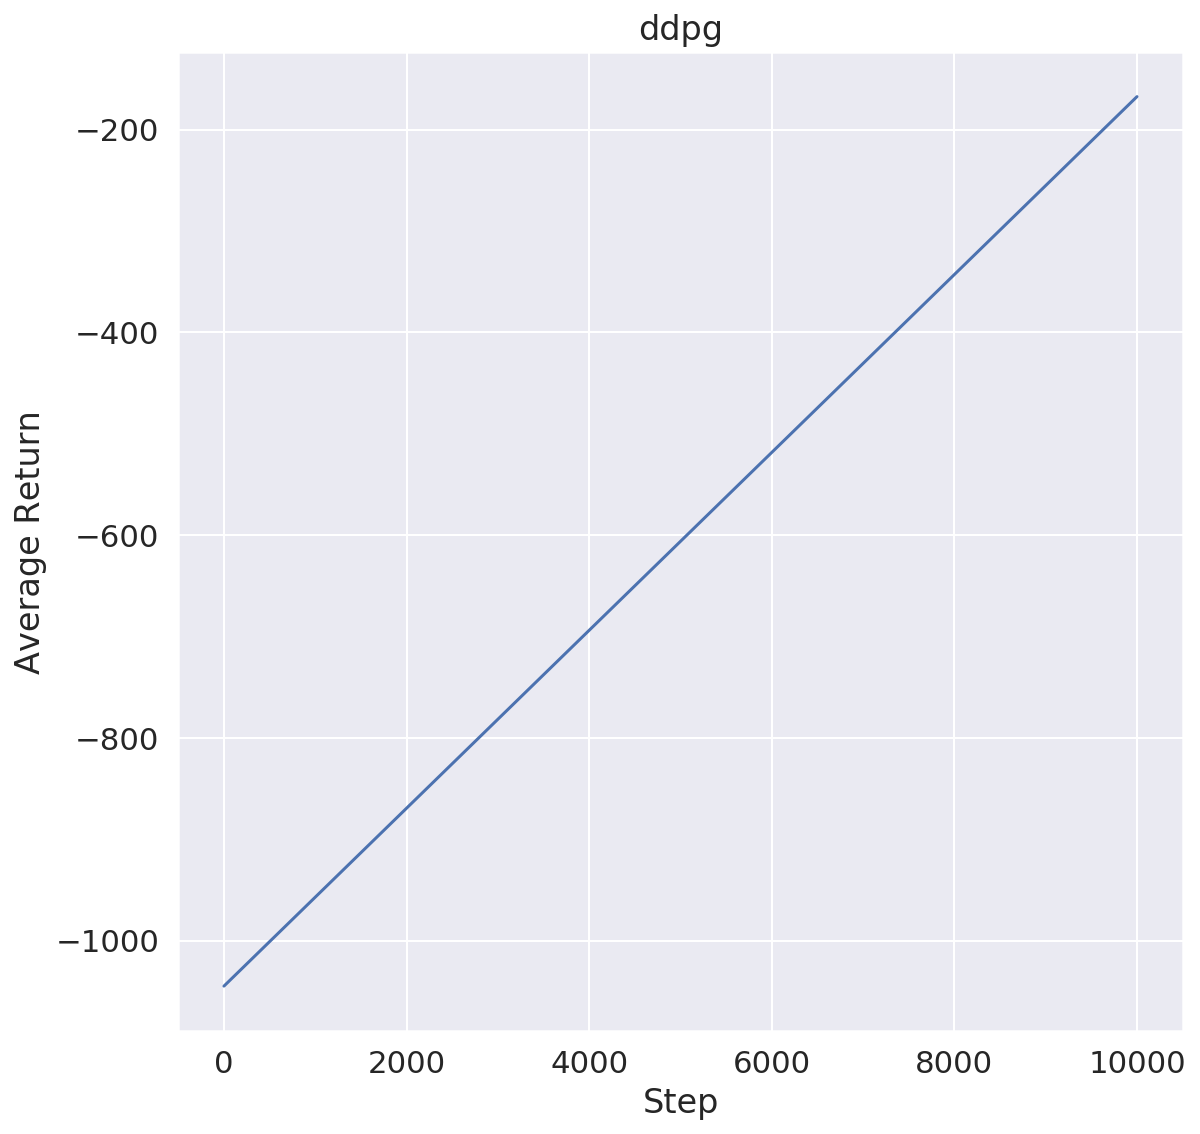

In [5]:
from tf_agents.agents.ddpg import ddpg_agent, actor_network, critic_network

actor_net = actor_network.ActorNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=actor_fc_layer_params)

critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(),  train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)

global_step = tf.compat.v2.Variable(0)
tf_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    train_step_counter=global_step)

returns, video_filename = train_and_evaluate_agent_ddpg(tf_agent, name='ddpg')
embed_mp4(video_filename)

# SAC

(Soft Actor-Critic) DDPG variant which uses stochastic policies, entropy regularization, and a few other tricks to stabilize learning and score higher than DDPG on standard benchmarks. Here optimizing a stochastic policy in an off-policy way. One of the key features of SAC is that it solves a maximum entropy reinforcement learning problem.

TF-Agents implements the Soft Actor-Critic (SAC) algorithm from ["Soft Actor-Critic Algorithms and Applications"](https://arxiv.org/abs/1812.05905) 2019.

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
step = 50: loss = 7.070254325866699
step = 100: loss = 6.559694766998291
step = 150: loss = 7.3626580238342285
step = 200: loss = 8.88958740234375
step = 250: loss = 8.262764930725098
step = 300: loss = 8.826142311096191
step = 350: loss = 10.381875991821289
step = 400: loss = 11.058186531066895
step = 450: loss = 12.148664474487305
step = 500: loss = 13.601359367370605
step = 550: loss = 15.202703475952148
step = 600: loss = 15.737838745117188
step = 650: loss = 17.622821807861328
step = 700: loss = 18.371736526489258
step = 750: loss = 22.125608444213867
step = 800: loss = 20.163368225097656
step = 850: loss = 21.731653213500

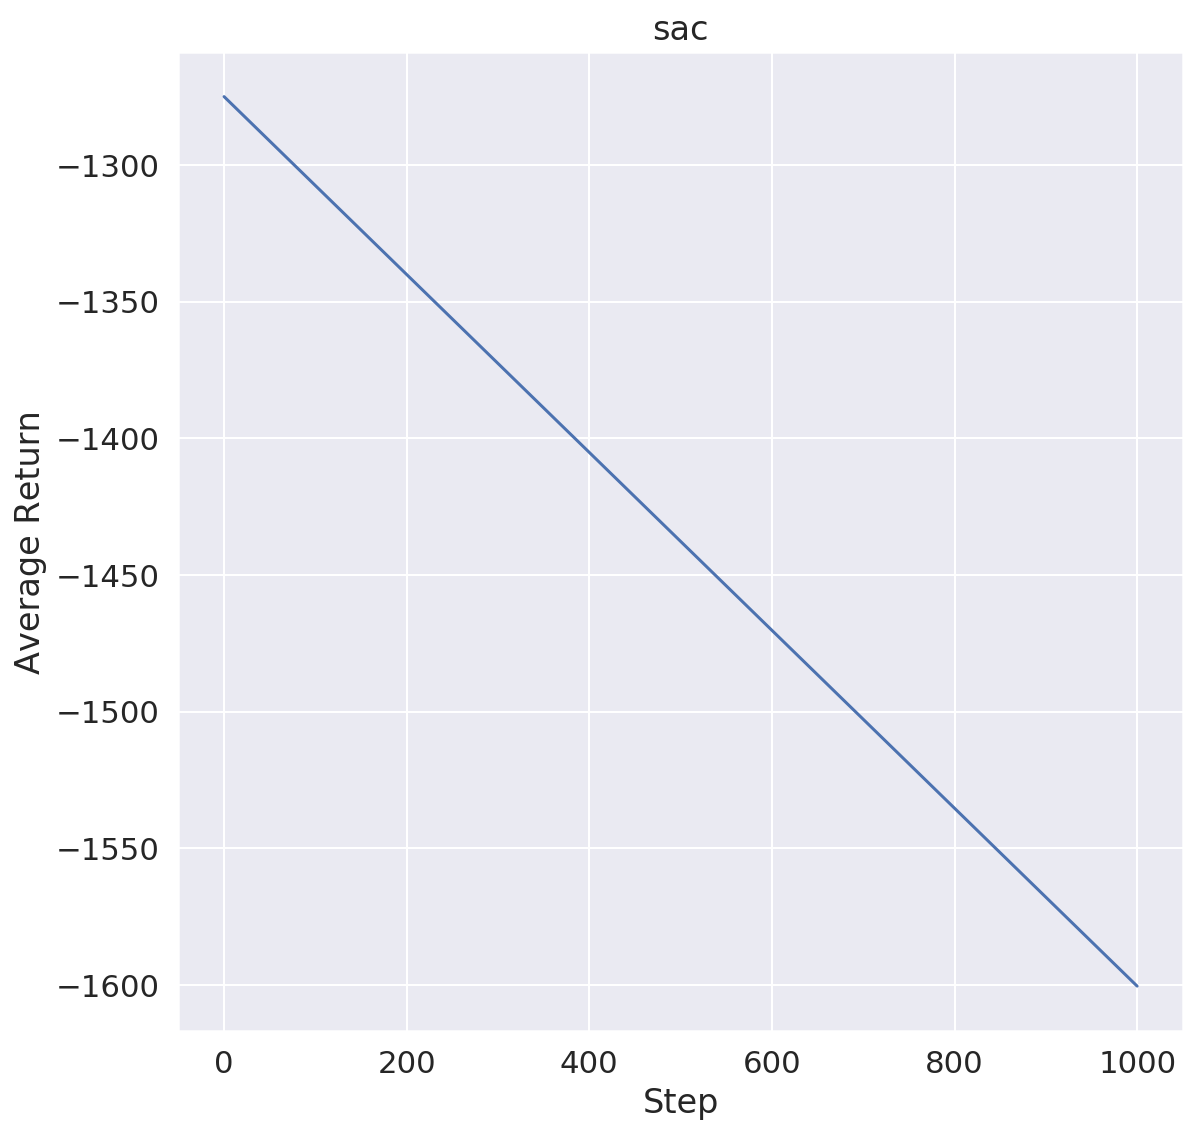

In [4]:
from tf_agents.agents.sac import sac_agent


def normal_projection_net(action_spec, init_means_output_factor=0.1):
    return normal_projection_network.NormalProjectionNetwork(
        action_spec,
        mean_transform=None,
        state_dependent_std=True,
        init_means_output_factor=init_means_output_factor,
        std_transform=sac_agent.std_clip_transform,
        scale_distribution=True)


critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(),  train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=actor_fc_layer_params,
    continuous_projection_net=normal_projection_net)

global_step = tf.compat.v2.Variable(0)
tf_agent = sac_agent.SacAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    train_step_counter=global_step)

returns, video_filename = train_and_evaluate_agent_ddpg(tf_agent, name='sac')
embed_mp4(video_filename)